In [1]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smop
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# url = ('https://github.com/ipython-books/'
#        'cookbook-2nd-data/blob/master/'
#        'road.zip?raw=true')
# r = io.BytesIO(requests.get(url).content)
# zipfile.ZipFile(r).extractall('data')
g = nx.read_shp('data/tl_2013_06_prisecroads.shp')

In [72]:
sgs = list(nx.connected_component_subgraphs(
    g.to_undirected()))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

464

In [73]:
pos0 = (36.1620,-115.1611)
pos1 = (38.4288,-122.7187)

In [74]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [75]:
# from https://stackoverflow.com/a/8859667/1595060
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [76]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))

In [77]:
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

In [78]:
pos0 = (36.1620,-115.1611)
pos1 = (38.4288,-122.7187)

In [79]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

In [90]:
# Compute the shortest path.
path = nx.shortest_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight='distance')
path

[(-117.73071, 33.639046),
 (-118.011398, 33.87453699999999),
 (-118.209305, 34.026714999999996),
 (-118.221347, 34.03455799999999),
 (-118.463282, 34.287148),
 (-118.474519, 34.29787199999999),
 (-118.489018, 34.31400099999999),
 (-118.501711, 34.323912),
 (-118.50195099999999, 34.324425999999995),
 (-118.512047, 34.336584),
 (-118.519549, 34.340424999999996),
 (-118.62745100000001, 34.502134999999996),
 (-118.67094, 34.55359399999999),
 (-118.87712, 34.803208999999995),
 (-119.782387, 35.78996),
 (-120.098157, 36.074646),
 (-120.777072, 36.855101999999995),
 (-121.088656, 37.24613),
 (-121.333388, 37.591049999999996),
 (-121.447774, 38.2551),
 (-121.626095, 38.673373999999995),
 (-121.800303, 38.71878199999999),
 (-122.01747300000001, 38.689448999999996),
 (-122.323393, 38.924057999999995),
 (-122.326969, 38.92402299999999),
 (-122.331925, 38.92396)]

In [89]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,Santa Ana Fwy,S1100,M,37.870947
1,I- 5,S1100,I,25.845502
2,I- 5,S1100,I,1.533983
3,I- 5,S1100,I,39.059281
4,I- 5,S1100,I,1.607192
5,Golden State Fwy,S1100,M,2.237699
6,Golden State Fwy,S1100,M,1.626531
7,Golden State Fwy,S1100,M,0.061274
8,I- 5,S1100,I,1.672594
9,Golden State Fwy,S1100,M,0.812173


In [82]:
roads['distance'].sum()

790.6195873113587

In [83]:
m = smop.Map((38.4288,-122.7187), (36.1620, -115.1611), z=7, margin=.1)

In [84]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [85]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

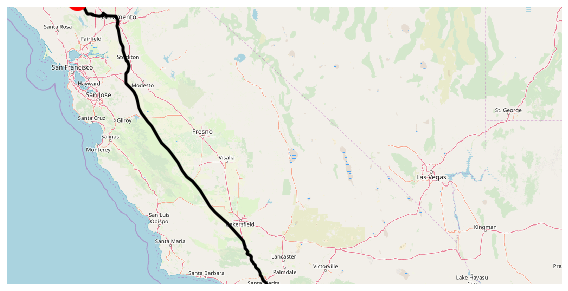

In [86]:
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)